
A minimal runnable script that:
  * loads/creates placeholder organoid graphs,
  * builds the dataset,
  * trains with the two-phase sparse procedure,
  * prints evaluation metrics and top coefficients,
  * saves history to disk for later plotting.


In [1]:
import numpy as np

from datastructures import *
from training import *
from models import *
from residuals import *

/home/fmoller/miniforge3/envs/organoid-gnn/lib/python3.11/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._show_config()


In [2]:
# Load all organoids
data_dir = "training_data"
graphs = load_dir_to_graphs(data_dir)
print(f"Loaded {len(graphs)} organoids.")

# Load metadata & attach
meta = load_aux_metadata_for_dir("training_data")
attached = attach_metadata_to_graphs(graphs, meta)
print(f"Attached metadata to {attached}/{len(graphs)} graphs.")

Loaded 1215 graphs; skipped 0.
Loaded 1215 organoids.
Attached metadata to 1215/1215 graphs.


In [3]:

# (Optional) global outlier filtering BEFORE split (applies to all)
low_pct, high_pct = 0.0, 100.0   # example: keep middle 0–95th percentile
graphs, thr = filter_outliers(graphs, low_pct=low_pct, high_pct=high_pct, stat="median")
print(f"After global filter: {len(graphs)} organoids | thresholds: {thr}")

After global filter: 1215 organoids | thresholds: {'low': -0.0022743481677025557, 'high': 0.8184399008750916}


In [4]:
# graphs: list[Data] already loaded and with .meta attached
complexities = []
for g in graphs:
    md = getattr(g, "meta", {}) or {}
    v = md.get("complexity", np.nan)
    try:
        v = float(v)
    except Exception:
        v = np.nan
    complexities.append(v)

complexities = np.asarray(complexities, dtype=float)
mask_keep = np.isfinite(complexities) & (complexities >= -1.0)

kept_graphs    = [g for g, m in zip(graphs, mask_keep) if m]
dropped_graphs = [g for g, m in zip(graphs, mask_keep) if not m]

print(f"Complexity filter: kept {len(kept_graphs)} / {len(graphs)} | "
      f"dropped {len(dropped_graphs)} (missing/NaN or < 1)")

# replace your working list
graphs = kept_graphs

Complexity filter: kept 1182 / 1215 | dropped 33 (missing/NaN or < 1)


In [5]:
# Split dataset by organoid
g_train, g_val = split_graphs(graphs, val_frac=0.1, seed=None)
print(f"Split -> train: {len(g_train)} | val: {len(g_val)}")


center, scale = standardize_targets(g_train, g_val, robust=True)

Split -> train: 1064 | val: 118


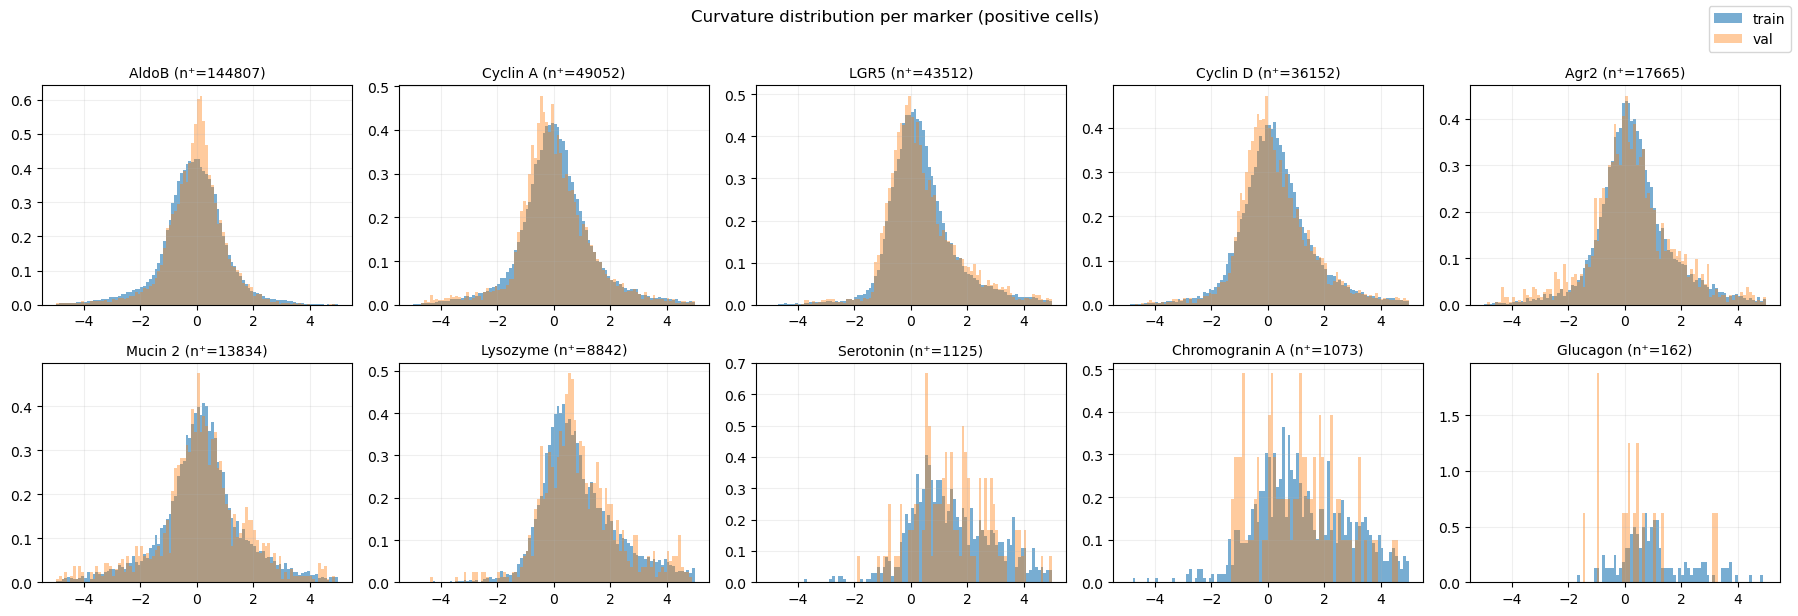

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from datastructures import load_marker_names_from_dir

# --- Collect X and y from train/val ---
X_train = np.vstack([g.x.cpu().numpy() for g in g_train])
y_train = np.concatenate([g.y.cpu().numpy() for g in g_train])
X_val   = np.vstack([g.x.cpu().numpy() for g in g_val])
y_val   = np.concatenate([g.y.cpu().numpy() for g in g_val])

M = X_train.shape[1]

# --- Marker names ---
marker_names = load_marker_names_from_dir("training_data")
if marker_names is None:
    marker_names = [f"m{j}" for j in range(M)]
else:
    marker_names = list(marker_names) + [f"m{j}" for j in range(len(marker_names), M)]

# --- Identify positives and rank markers by prevalence ---
pos_train = X_train > 0.5
n_pos = pos_train.sum(axis=0)
order = np.argsort(-n_pos)
marker_idx_show = order[:min(12, M)]          # show up to 12 markers
marker_names_sel = [marker_names[m] for m in marker_idx_show]

# --- Curvature values for positives ---
curv_train = [y_train[pos_train[:, m]] for m in marker_idx_show]
curv_val   = [y_val[(X_val > 0.5)[:, m]] for m in marker_idx_show]

# --- Histogram binning ---
edges = np.linspace(-5, 5, 101)
# --- Plot ---
cols = 5
rows = int(np.ceil(len(marker_idx_show) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.6, rows * 3.0), squeeze=False)
axes = axes.ravel()

for i, m in enumerate(marker_idx_show):
    ax = axes[i]
    ax.hist(curv_train[i], bins=edges, density=True, alpha=0.6, label="train")
    ax.hist(curv_val[i],   bins=edges, density=True, alpha=0.4, label="val")
    ax.set_title(f"{marker_names_sel[i]} (n⁺={n_pos[m]})", fontsize=10)
    ax.grid(alpha=0.2)

# hide unused axes
for j in range(len(marker_idx_show), len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.suptitle("Curvature distribution per marker (positive cells)", y=1.02)

plt.tight_layout()
plt.show()


In [7]:
num_layers = 3
# num_hops   = num_layers
# ego_train  = build_ego_dataset(
#     g_train,
#     num_hops=num_hops,
#     max_centers_per_graph=None,  # e.g. 80 random centers per organoid
#     seed=0,
# )


In [8]:

# Build the model
n_markers = int(g_train[0].x.size(1))
model = PureSAGECurvature(
    n_markers=n_markers,
    hidden_dim=2*64,
    num_layers=num_layers,
    dropout=0.1,      
    residual=True,
    norm='batch'      
)



cfg = TrainConfig(
    lr=1e-3,          
    batch_size=128,
    max_epochs=100,   
    patience=30,
    huber_delta=1.0,
    lambda_calib=0,     
    calib_mode="corr",
    num_workers=4, 
)


In [9]:

model, metrics, history = train(model, g_train, g_val, cfg)

# # from training import train_lbfgs
# model, metrics, history = train_lbfgs(
#     model, g_train, g_val, cfg,
#     outer_steps=50,   # try 30–80
#     lr=0.5,           # try 0.2–1.0
#     max_iter=20,      # internal line-search iterations
#     history_size=100
# )
# print("Best val MAE:", metrics["val_mae"])


/home/fmoller/miniforge3/envs/organoid-gnn/lib/python3.11/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 001 | train loss 0.9088 mae 1.3225 | val loss 0.5773 mae 0.9511
epoch 002 | train loss 0.6478 mae 1.0345 | val loss 0.5881 mae 0.9683
epoch 003 | train loss 0.6122 mae 0.9944 | val loss 0.5484 mae 0.9146
epoch 004 | train loss 0.5973 mae 0.9750 | val loss 0.5432 mae 0.9089
epoch 005 | train loss 0.5920 mae 0.9703 | val loss 0.5375 mae 0.9047
epoch 006 | train loss 0.5831 mae 0.9599 | val loss 0.5290 mae 0.8876
epoch 007 | train loss 0.5859 mae 0.9627 | val loss 0.5385 mae 0.9076
epoch 008 | train loss 0.5761 mae 0.9505 | val loss 0.5311 mae 0.8967
epoch 009 | train loss 0.5720 mae 0.9465 | val loss 0.5254 mae 0.8873
epoch 010 | train loss 0.5686 mae 0.9420 | val loss 0.5374 mae 0.9058
epoch 011 | train loss 0.5741 mae 0.9489 | val loss 0.5252 mae 0.8884
epoch 012 | train loss 0.5689 mae 0.9424 | val loss 0.5231 mae 0.8819
epoch 013 | train loss 0.5656 mae 0.9388 | val loss 0.5217 mae 0.8802
epoch 014 | train loss 0.5621 mae 0.9342 | val loss 0.5312 mae 0.8996
epoch 015 | train lo

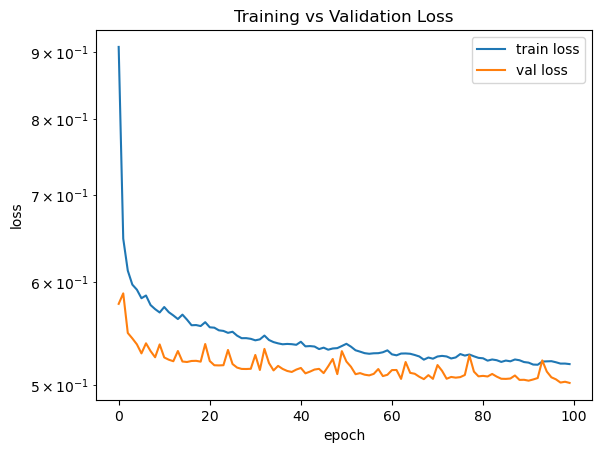

In [10]:
import json, os
import matplotlib.pyplot as plt

def _load_history_fallback():
    path = "artifacts/history.json"
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

# Use in-memory 'history' if present; else load from disk
try:
    _hist = history
except NameError:
    _hist = _load_history_fallback()

if _hist is None:
    print("No history found. Define a `history` dict or save it to artifacts/history.json.")
else:
    # Loss
    plt.figure()
    plt.plot(_hist.get("train_loss", []), label="train loss")
    plt.plot(_hist.get("val_loss", []), label="val loss")
    plt.yscale('log')
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training vs Validation Loss")
    plt.legend(); plt.show()


In [11]:
import matplotlib.pyplot as plt
from analysis_basic import *

device = cfg.device if 'cfg' in globals() else ('cuda' if torch.cuda.is_available() else 'cpu')
marker_names = load_marker_names_from_dir(data_dir)

# === Inference on VALIDATION ===
y, yhat, X = run_inference(g_val, model, device=device)

# transform back 
y    = y  * scale + center
yhat = yhat * scale + center

# Residuals per marker (positives only)
residuals_model, residuals_base, n_pos, mu_pos = residuals_per_marker(y, yhat, X)


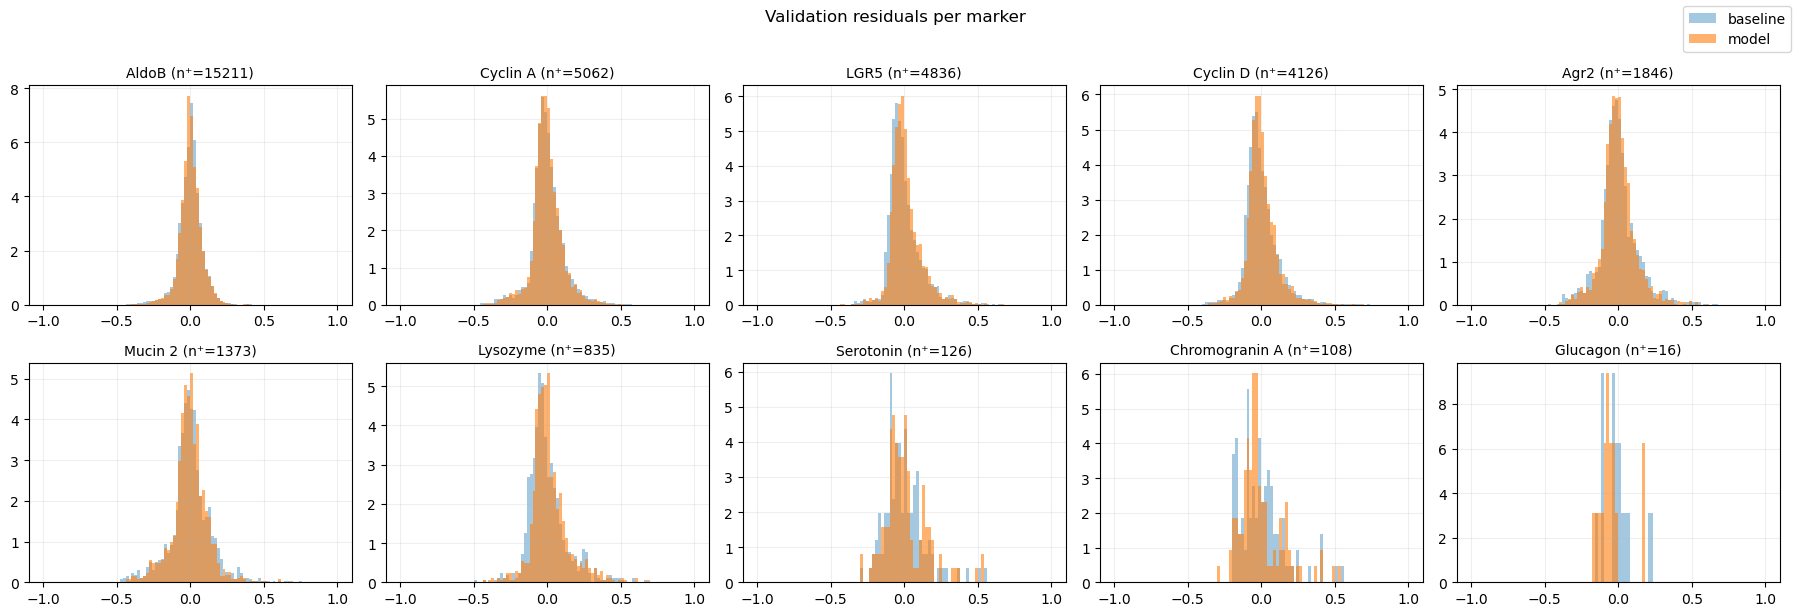

In [12]:
# Helper: pick top markers by positives for display
order_by_n = np.argsort(-n_pos)
marker_idx_show = order_by_n[:min(12, (X.shape[1] if X.ndim == 2 else 12))]
marker_names_sel = [marker_names[m] if m < len(marker_names) else f"m{m}" for m in marker_idx_show]

# === Histograms of residuals per marker (model vs baseline) ===
cols = 5; rows = int(np.ceil(len(marker_idx_show)/cols)) if len(marker_idx_show) else 1
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.6, rows*3.0), squeeze=False)
axes = axes.ravel()
edges = np.linspace(-1.0, 1.0, 101)  # symmetric bins

for k, m in enumerate(marker_idx_show):
    ax = axes[k]
    rb = residuals_base[m]; rm = residuals_model[m]
    if rb.size == 0:
        ax.axis('off'); continue
    ax.hist(rb, bins=edges, density=True, alpha=0.4, label="baseline")
    ax.hist(rm, bins=edges, density=True, alpha=0.6, label="model")
    ax.set_title(f"{marker_names_sel[k]} (n⁺={n_pos[m]})", fontsize=10)
    ax.grid(True, alpha=0.2)

for k in range(len(marker_idx_show), len(axes)):
    axes[k].axis('off')
if len(marker_idx_show):
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
fig.suptitle("Validation residuals per marker", y=1.02)
plt.tight_layout(); plt.show()


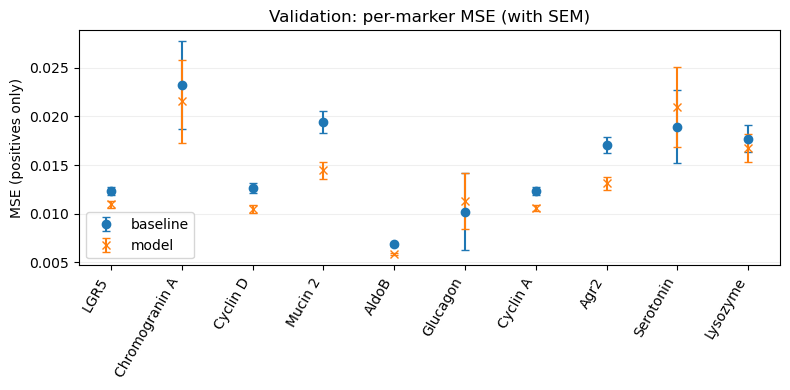

In [13]:
# MSE and SEM (SEM over squared residuals)
mse_model = np.array([np.mean(r**2) for r in residuals_model])
mse_base  = np.array([np.mean(r**2) for r in residuals_base])
sem_model = np.array([np.std((r**2), ddof=1)/np.sqrt(r.size) for r in residuals_model])
sem_base  = np.array([np.std((r**2), ddof=1)/np.sqrt(r.size) for r in residuals_base])

x = np.arange(len(marker_names))

plt.figure(figsize=(max(8, 0.5*len(marker_names)), 4))
plt.errorbar(x, mse_base,  yerr=sem_base,  fmt='o', capsize=3, label="baseline")
plt.errorbar(x, mse_model, yerr=sem_model, fmt='x', capsize=3, label="model")
plt.xticks(x, marker_names, rotation=60, ha='right')
plt.ylabel("MSE (positives only)")
plt.title("Validation: per-marker MSE (with SEM)")
plt.grid(True, axis='y', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


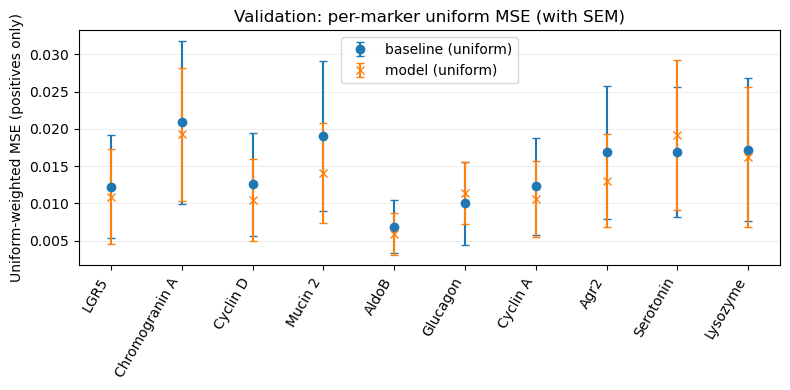

In [14]:
# ===  Uniformly weighted MSE per marker (model and baseline) ===
# Build y/pred lists per marker once (positives only)
# Build per-marker slices (positives only)
y_list     = [y[X[:, m] > 0.5] for m in range(X.shape[1])]
yhat_list  = [yhat[X[:, m] > 0.5] for m in range(X.shape[1])]
ybase_list = [np.full_like(y_list[m], mu_pos[m]) for m in range(X.shape[1])]

uw_model, se_model = uniform_weighted_mse(y_list, yhat_list, nbins=8, strategy="quantile")
uw_base,  se_base  = uniform_weighted_mse(y_list, ybase_list, nbins=8, strategy="quantile")

x = np.arange(len(marker_names))
plt.figure(figsize=(max(8, 0.5*len(marker_names)), 4))
plt.errorbar(x, uw_base,  yerr=se_base,  fmt='o', capsize=3, label="baseline (uniform)")
plt.errorbar(x, uw_model, yerr=se_model, fmt='x', capsize=3, label="model (uniform)")
plt.xticks(x, marker_names, rotation=60, ha='right')
plt.ylabel("Uniform-weighted MSE (positives only)")
plt.title("Validation: per-marker uniform MSE (with SEM)")
plt.grid(True, axis='y', alpha=0.2)
plt.legend(); plt.tight_layout(); plt.show()



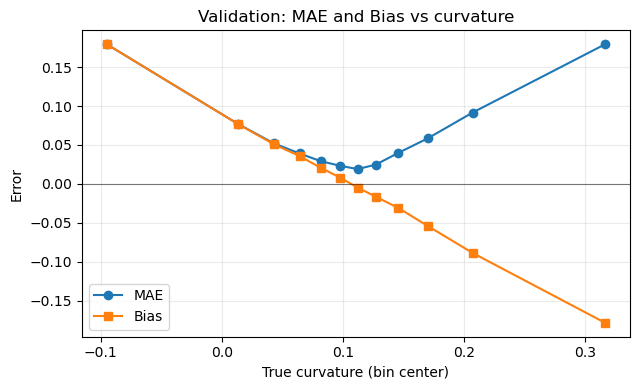

In [15]:
# === total MAE + bias vs (binned) curvature (global) ===
edges_glob, centers_glob = build_bins_from_true(y, nbins=12, strategy="quantile")

counts_glob, mae_glob, _, _ = bin_by_curvature(y, np.abs(yhat - y), edges=edges_glob, strategy="quantile")
_, bias_glob, _, _ = bin_by_curvature(y, (yhat - y), edges=edges_glob, strategy="quantile")

plt.figure(figsize=(6.5, 4))
plt.plot(centers_glob, mae_glob,  'o-', label="MAE")
plt.plot(centers_glob, bias_glob, 's-', label="Bias")
plt.axhline(0.0, color='k', lw=0.8, alpha=0.5)
plt.xlabel("True curvature (bin center)")
plt.ylabel("Error")
plt.title("Validation: MAE and Bias vs curvature")
plt.grid(True, alpha=0.25)
plt.legend(); plt.tight_layout(); plt.show()


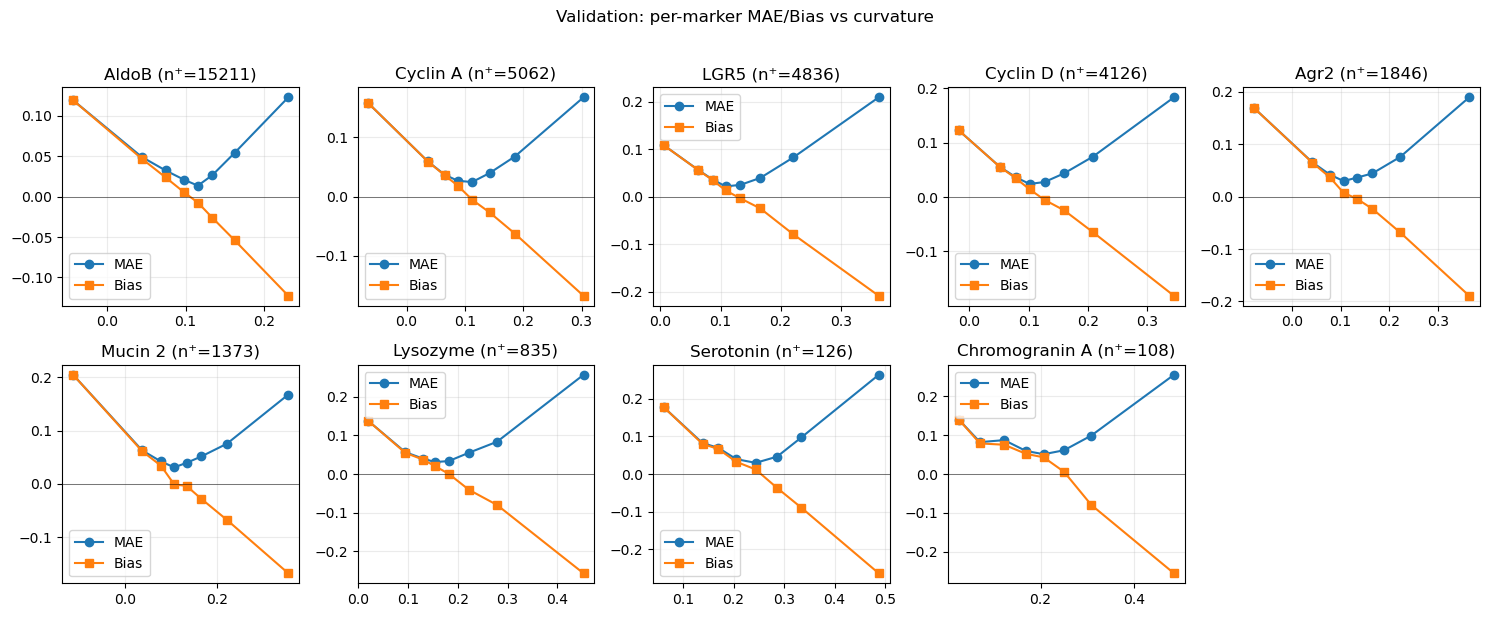

In [16]:
# === MAE + bias per marker vs (binned) curvature ===
# Build per-marker lists (positives only)
abs_res_list = [np.abs(yhat[X[:, m] > 0.5] - y[X[:, m] > 0.5]) for m in range(X.shape[1])]
res_list     = [      yhat[X[:, m] > 0.5] - y[X[:, m] > 0.5]   for m in range(X.shape[1])]
y_pos_list   = [y[X[:, m] > 0.5] for m in range(X.shape[1])]

# Bin each series by its own curvature distribution (quantile bins)
cnt_mae_list,  mae_list,  _, centers_mae_list  = bin_by_curvature(
    y_pos_list, abs_res_list, edges=None, nbins=8, strategy="quantile"
)
cnt_bias_list, bias_list, _, centers_bias_list = bin_by_curvature(
    y_pos_list, res_list,     edges=None, nbins=8, strategy="quantile"
)

max_markers = 12
order_by_n  = np.argsort(-n_pos)
selm        = [m for m in order_by_n if len(y_pos_list[m]) >= 30][:max_markers]

cols = 5
rows = int(np.ceil(len(selm)/cols)) if len(selm) else 1
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3), squeeze=False)
axes = axes.ravel()

for k, m in enumerate(selm):
    ax = axes[k]
    centers_m = centers_mae_list[m]  # same binning for abs_res and res (both from quantile on y_pos_list[m])
    ax.plot(centers_m, mae_list[m],  'o-', label="MAE")
    ax.plot(centers_m, bias_list[m], 's-', label="Bias")
    ax.axhline(0.0, color='k', lw=0.7, alpha=0.5)
    ax.set_title(f"{marker_names[m] if m < len(marker_names) else f'm{m}'} (n⁺={n_pos[m]})")
    ax.grid(True, alpha=0.25)
    ax.legend()

for k in range(len(selm), len(axes)):
    axes[k].axis('off')

fig.suptitle("Validation: per-marker MAE/Bias vs curvature", y=1.02)
plt.tight_layout(); plt.show()


In [17]:
from graph_audit import audit_dataset, ablation_edges_and_shuffle

# Quick sample audit (prints warnings inline)
_ = audit_dataset(g_train, sample_k=5, marker_names=marker_names, seed=0)

# Global ablation sanity on the whole train set
abl = ablation_edges_and_shuffle(model, g_train, device=cfg.device, batch_size=8)
print("\nAblations on TRAIN:")
for k, v in abl.items():
    print(f"  {k:>10s} -> MAE={v['MAE']:.4f}  MSE={v['MSE']:.6f}")

# (optional) also run on validation
abl_val = ablation_edges_and_shuffle(model, g_val, device=cfg.device, batch_size=8)
print("\nAblations on VAL:")
for k, v in abl_val.items():
    print(f"  {k:>10s} -> MAE={v['MAE']:.4f}  MSE={v['MSE']:.6f}")



=== Graph #675 ===
[Graph audit]
- nodes=506 edges=3032 | out_of_range=0 self_loops=0 dup_dir=3032 undirected_symmetry=1.000
- deg0_frac=0.000 deg_mean=5.99 p90=7.0 max=9
- components=1 (small<=5: 0) largest=506
- two_hop_cover_frac≈0.039 | Moran-I(y)≈0.881
- homophily same_frac(mean across markers)≈0.957

=== Graph #542 ===
[Graph audit]
- nodes=247 edges=1464 | out_of_range=0 self_loops=0 dup_dir=1464 undirected_symmetry=1.000
- deg0_frac=0.004 deg_mean=5.93 p90=7.0 max=8
- components=2 (small<=5: 1) largest=246
- two_hop_cover_frac≈0.077 | Moran-I(y)≈0.817
- homophily same_frac(mean across markers)≈0.996

=== Graph #286 ===
[Graph audit]
- nodes=348 edges=2078 | out_of_range=0 self_loops=0 dup_dir=2078 undirected_symmetry=1.000
- deg0_frac=0.000 deg_mean=5.97 p90=7.0 max=9
- components=1 (small<=5: 0) largest=348
- two_hop_cover_frac≈0.056 | Moran-I(y)≈0.886
- homophily same_frac(mean across markers)≈0.958

=== Graph #327 ===
[Graph audit]
- nodes=168 edges=996 | out_of_range=0 sel